In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from scipy.special import expit as invlogit

from numpy.random import default_rng

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)
az.style.use('arviz-darkgrid')
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 15.1

In [4]:
# Simulate a pancake and return randomly ordered sides
def sim_pancake():
    pancake = rng.integers(3)
    sides = np.array([[1, 1], [1, 0], [0, 0]])[pancake]
    return rng.permutation(sides)

# Simulate 10,000 pancakes
pancakes = np.array([sim_pancake() for i in range(10000)])
up = pancakes[:, 0]
down = pancakes[:, 1]

# Compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up==1)
num_11 = np.sum((up==1) & (down==1))
print(f'{round(num_11 / num_11_10, 2)}')

0.66


#### Code 15.2

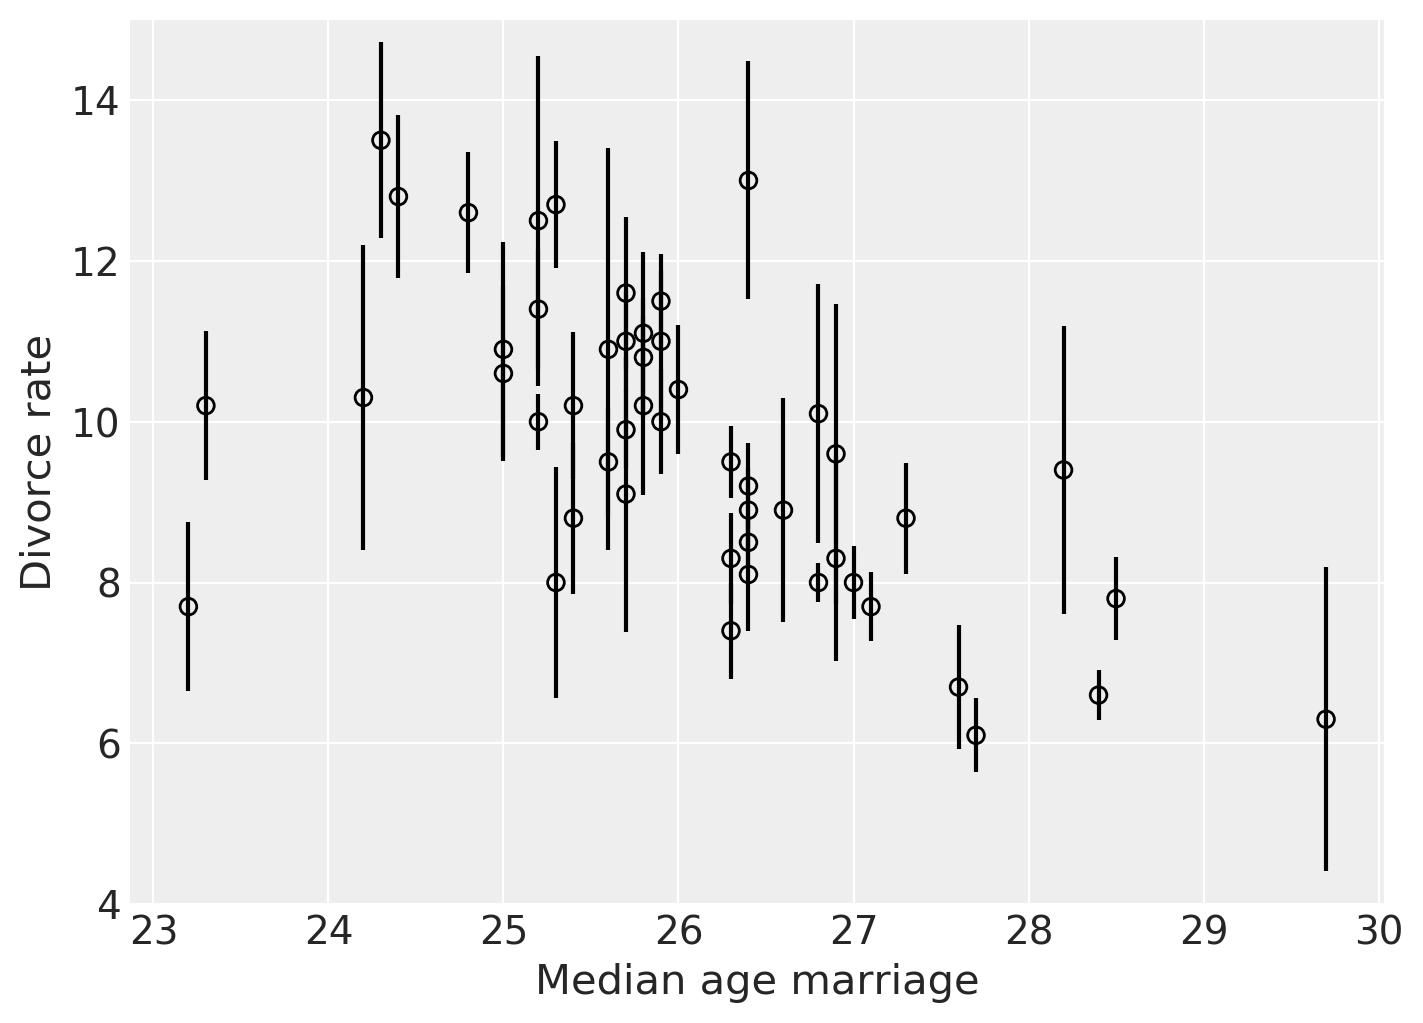

In [5]:
d = pd.read_csv('Data/WaffleDivorce.csv', ';')

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(d['MedianAgeMarriage'], d['Divorce'], edgecolor='k', facecolor='none')
ax.errorbar(d['MedianAgeMarriage'] ,d['Divorce'], yerr=d['Divorce SE'], fmt='none', c='k')

ax.set_ylim(4, 15)
ax.set_xlabel('Median age marriage')
ax.set_ylabel('Divorce rate');

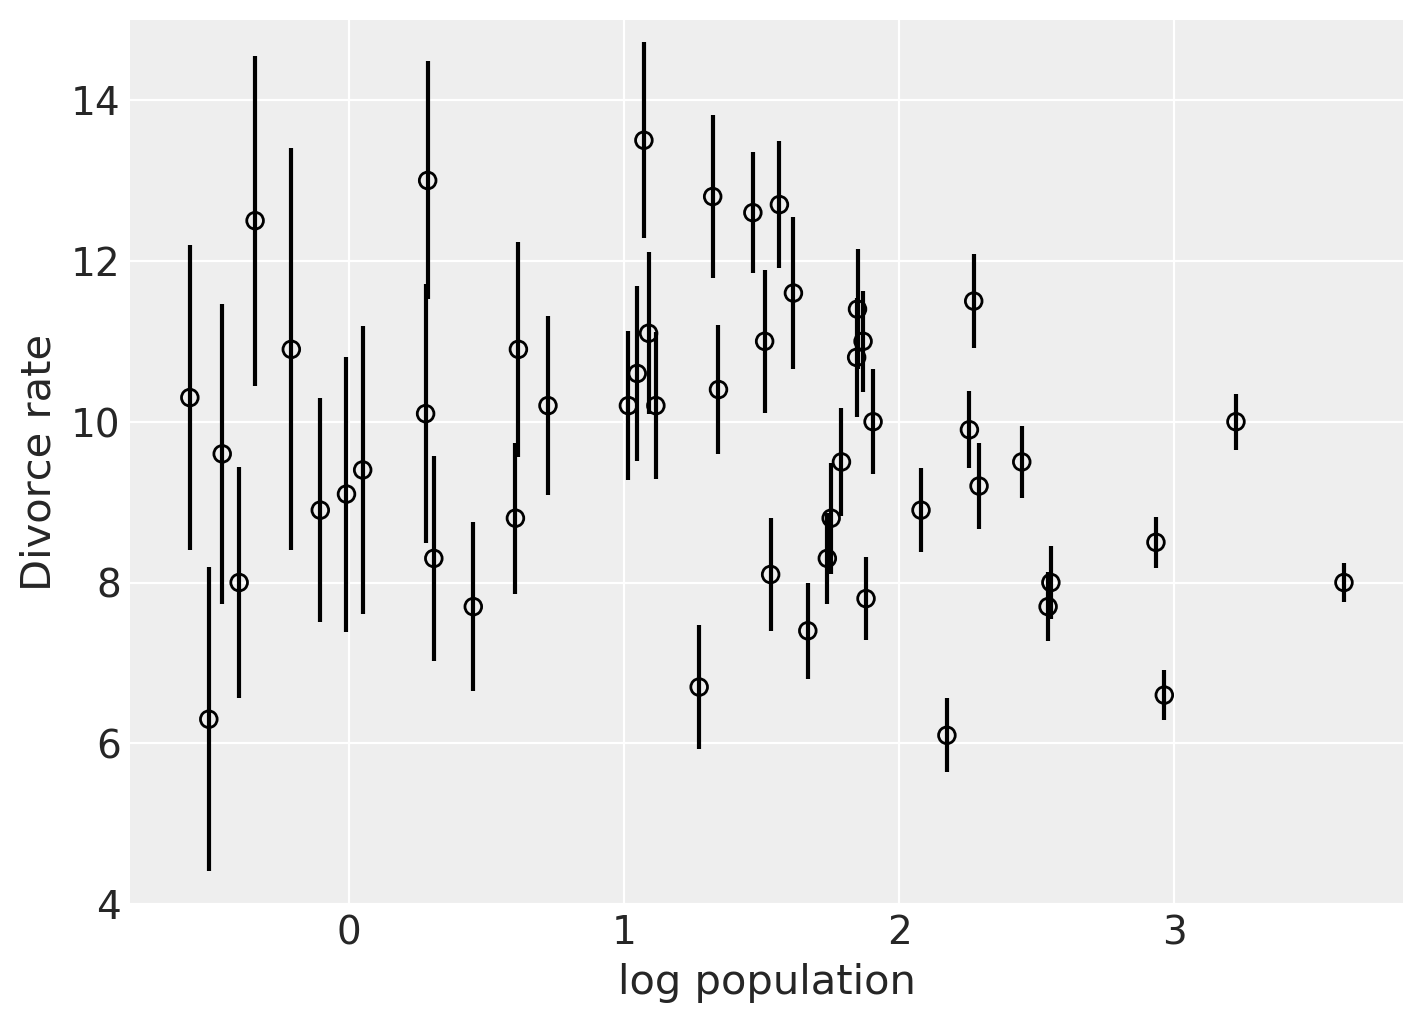

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(np.log(d['Population']), d['Divorce'], edgecolor='k', facecolor='none')
ax.errorbar(np.log(d['Population']) ,d['Divorce'], yerr=d['Divorce SE'], fmt='none', c='k')

ax.set_ylim(4, 15)
ax.set_xlabel('log population')
ax.set_ylabel('Divorce rate');

#### Code 15.3

In [7]:
D_obs = standardize(d['Divorce'])
D_sd = d['Divorce SE'] / d['Divorce'].std()
M = standardize(d['Marriage'])
A = standardize(d['MedianAgeMarriage'])
N = len(d)

with pm.Model() as m15_1:
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', 0, 0.5)
    bA = pm.Normal('bA', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    
    mu = a + bA*A + bM*M
    D_true = pm.Normal('D_true', mu, sigma, shape=N)
    
    D = pm.Normal('D_obs', D_true, D_sd, observed=D_obs)
    
    idata_m15_1 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### Code 15.4

In [8]:
az.summary(idata_m15_1, var_names=['~D_true'], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,0.05,0.17,-0.25,0.30,0.0,0.0,1344.99,1344.99,1356.46,1437.04,1.0
bA,-0.62,0.16,-0.86,-0.33,0.0,0.0,1526.34,1516.92,1529.31,1900.31,1.0
a,-0.05,0.10,-0.21,0.10,0.0,0.0,3053.29,3034.08,3062.76,2791.85,1.0
sigma,0.59,0.10,0.43,0.75,0.0,0.0,1252.89,1252.89,1214.99,1370.64,1.0


#### Code 15.5

In [9]:
D_obs = standardize(d['Divorce'])
D_sd = d['Divorce SE'] / d['Divorce'].std()
M_obs = standardize(d['Marriage'])
M_sd = d['Marriage SE'] / d['Marriage'].std()
A = standardize(d['MedianAgeMarriage'])
N = len(d)

with pm.Model() as m15_2:
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', 0, 0.5)
    bA = pm.Normal('bA', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    
    M_true = pm.Normal('M_true', 0, 1, shape=N)
    mu = a + bA*A + bM*M_true
    D_true = pm.Normal('D_true', mu, sigma, shape=N)
    
    D = pm.Normal('D_obs', D_true, D_sd, observed=D_obs)
    M = pm.Normal('M_obs', M_true, M_sd, observed=M_obs)
    
    idata_m15_2 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
    
az.summary(idata_m15_2, var_names=['~D_true', '~M_true'], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, M_true, a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,0.20,0.20,-0.13,0.50,0.01,0.0,1245.29,1211.85,1241.50,1562.83,1.0
bA,-0.54,0.16,-0.79,-0.30,0.00,0.0,1663.76,1649.45,1662.89,2209.17,1.0
a,-0.04,0.09,-0.19,0.10,0.00,0.0,2369.65,2347.27,2375.87,2908.00,1.0
sigma,0.56,0.11,0.37,0.71,0.00,0.0,718.71,718.71,637.86,388.02,1.0


#### Code 15.6

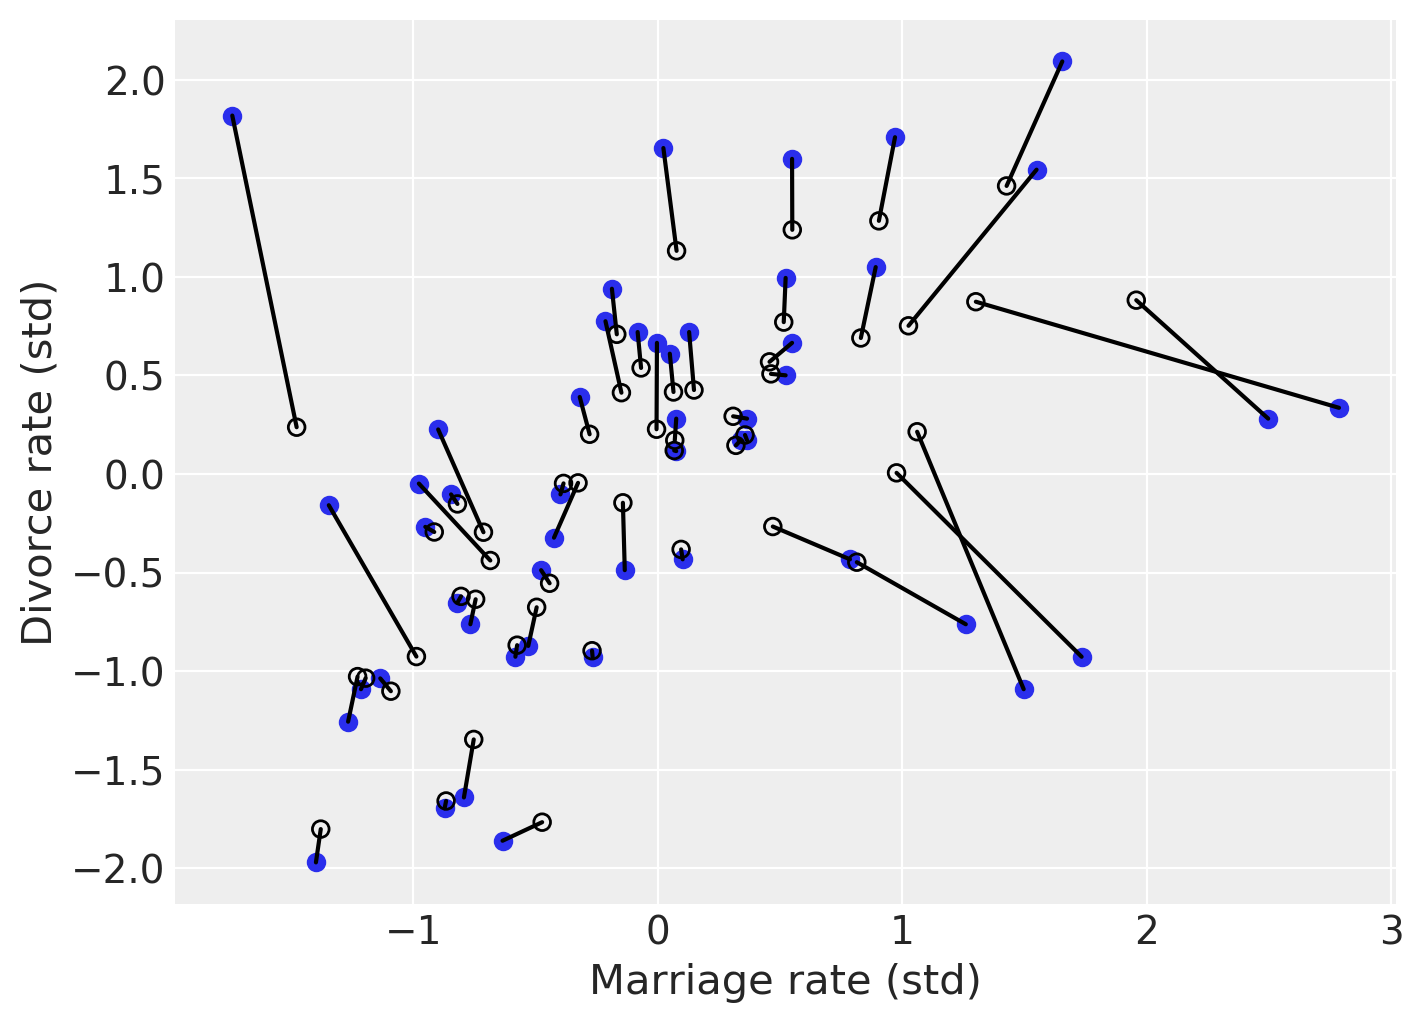

In [10]:
D_true = idata_m15_2.posterior['D_true'].mean(dim=['chain', 'draw'])
M_true = idata_m15_2.posterior['M_true'].mean(dim=['chain', 'draw'])

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M_obs, D_obs)
ax.scatter(M_true, D_true, edgecolor='k', facecolor='none')
ax.plot([M_obs, M_true], [D_obs, D_true], c='k')
    
ax.set_xlabel('Marriage rate (std)')
ax.set_ylabel('Divorce rate (std)');

#### Code 15.11

In [11]:
N = 1000
X = rng.normal(size=N)
S = rng.normal(size=N)
H = rng.binomial(n=10, p=invlogit(2 + S - 2*X), size=N)
D = X > 1

#### Code 15.12

In [12]:
with pm.Model() as m15_3:
    bS = pm.Normal('bS', 0, 0.5)
    a = pm.Normal('a', 0, 1)
    
    p = pm.invlogit(a + bS*S)
    
    H_model = pm.Binomial('H_model', n=10, p=p, observed=H)
    
    idata_m15_3 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
    
az.summary(idata_m15_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bS]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bS,0.62,0.03,0.58,0.66,0.0,0.0,3007.96,3007.96,2993.06,2725.48,1.0
a,1.25,0.02,1.21,1.29,0.0,0.0,3228.33,3227.88,3234.52,2490.29,1.0


#### Code 15.13

In [13]:
H_star = H[D==0]
S_star = S[D==0]

with pm.Model() as m15_4:
    bS = pm.Normal('bS', 0, 0.5)
    a = pm.Normal('a', 0, 1)
    
    p = pm.invlogit(a + bS*S_star)
    
    Hi = pm.Binomial('Hi', n=10, p=p, observed=H_star)
    
    idata_m15_4 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
    
az.summary(idata_m15_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bS]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bS,0.77,0.03,0.72,0.83,0.0,0.0,2713.61,2713.53,2729.88,2854.66,1.0
a,1.85,0.03,1.79,1.90,0.0,0.0,3072.95,3072.87,3080.89,2812.46,1.0


#### Code 15.16

In [14]:
d = pd.read_csv('Data/milk.csv', sep=';')
d['neocortex.prop'] = d['neocortex.perc'] / 100
d['logmass'] = np.log(d['mass'])

K = standardize(d['kcal.per.g'])
B = standardize(d['neocortex.prop'])
M = standardize(d['logmass'])

#### Code 15.17

In [15]:
with pm.Model() as m15_5:
    sigma_B = pm.Exponential('sigma_B', 1)
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', 0, 0.5)
    bB = pm.Normal('bB', 0, 0.5)
    nu = pm.Normal('nu', 0, 0.5)
    a = pm.Normal('a', 0, 0.5) 
    
    # PyMC3 automatically imputes missing values
    Bi = pm.Normal('Bi', nu, sigma_B, observed=B)
    
    mu = a + bB*Bi + bM*M
    
    Ki = pm.Normal('Ki', mu, sigma, observed=K)
    
    idata_m15_5 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
az.summary(idata_m15_5, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bi_missing, a, nu, bB, bM, sigma, sigma_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.55,0.20,-0.86,-0.22,0.00,0.00,2764.78,2596.56,2734.77,2642.59,1.0
bB,0.50,0.24,0.14,0.90,0.01,0.00,1792.56,1754.32,1773.11,2357.66,1.0
nu,-0.05,0.21,-0.38,0.28,0.00,0.00,3569.33,2351.88,3546.79,2477.35,1.0
a,0.03,0.16,-0.22,0.28,0.00,0.00,4735.44,1922.04,4688.47,2817.24,1.0
Bi_missing[0],-0.59,0.93,-2.04,0.92,0.01,0.01,4011.62,2624.37,4042.47,3037.57,1.0
Bi_missing[1],-0.72,0.94,-2.17,0.77,0.02,0.01,3824.63,2204.99,3838.97,1896.67,1.0
Bi_missing[2],-0.71,0.96,-2.22,0.76,0.02,0.01,3792.90,2665.53,3859.52,2763.47,1.0
Bi_missing[3],-0.30,0.88,-1.75,1.05,0.01,0.01,4700.51,1917.01,4719.29,2736.53,1.0
Bi_missing[4],0.46,0.91,-1.11,1.84,0.01,0.01,5802.45,2316.41,5801.45,2997.44,1.0
Bi_missing[5],-0.17,0.87,-1.47,1.26,0.01,0.01,4426.27,2219.83,4482.34,3161.65,1.0


#### Code 15.19

In [16]:
obs_idx = ~d['neocortex.prop'].isna()
K_obs = K[obs_idx]
B_obs = B[obs_idx]
M_obs = M[obs_idx]

with pm.Model() as m15_6:
    sigma_B = pm.Exponential('sigma_B', 1)
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', 0, 0.5)
    bB = pm.Normal('bB', 0, 0.5)
    nu = pm.Normal('nu', 0, 0.5)
    a = pm.Normal('a', 0, 0.5) 
    
    Bi = pm.Normal('Bi', nu, sigma_B, observed=B_obs)
    
    mu = a + bB*Bi + bM*M_obs
    
    Ki = pm.Normal('Ki', mu, sigma, observed=K_obs)
    
    idata_m15_6 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
az.summary(idata_m15_6, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, nu, bB, bM, sigma, sigma_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.64,0.25,-1.03,-0.24,0.00,0.0,2820.02,2820.02,2849.76,2864.78,1.0
bB,0.60,0.28,0.13,1.03,0.01,0.0,2815.06,2815.06,2836.33,2718.52,1.0
nu,0.00,0.22,-0.33,0.38,0.00,0.0,3541.07,1745.32,3595.88,2069.66,1.0
a,0.10,0.20,-0.22,0.41,0.00,0.0,3468.75,2093.44,3486.79,2239.73,1.0
sigma_B,1.03,0.19,0.74,1.30,0.00,0.0,2967.18,2745.11,3261.36,2313.01,1.0
sigma,0.87,0.19,0.59,1.14,0.00,0.0,2461.59,2461.59,2443.44,2291.38,1.0


#### Code 15.20

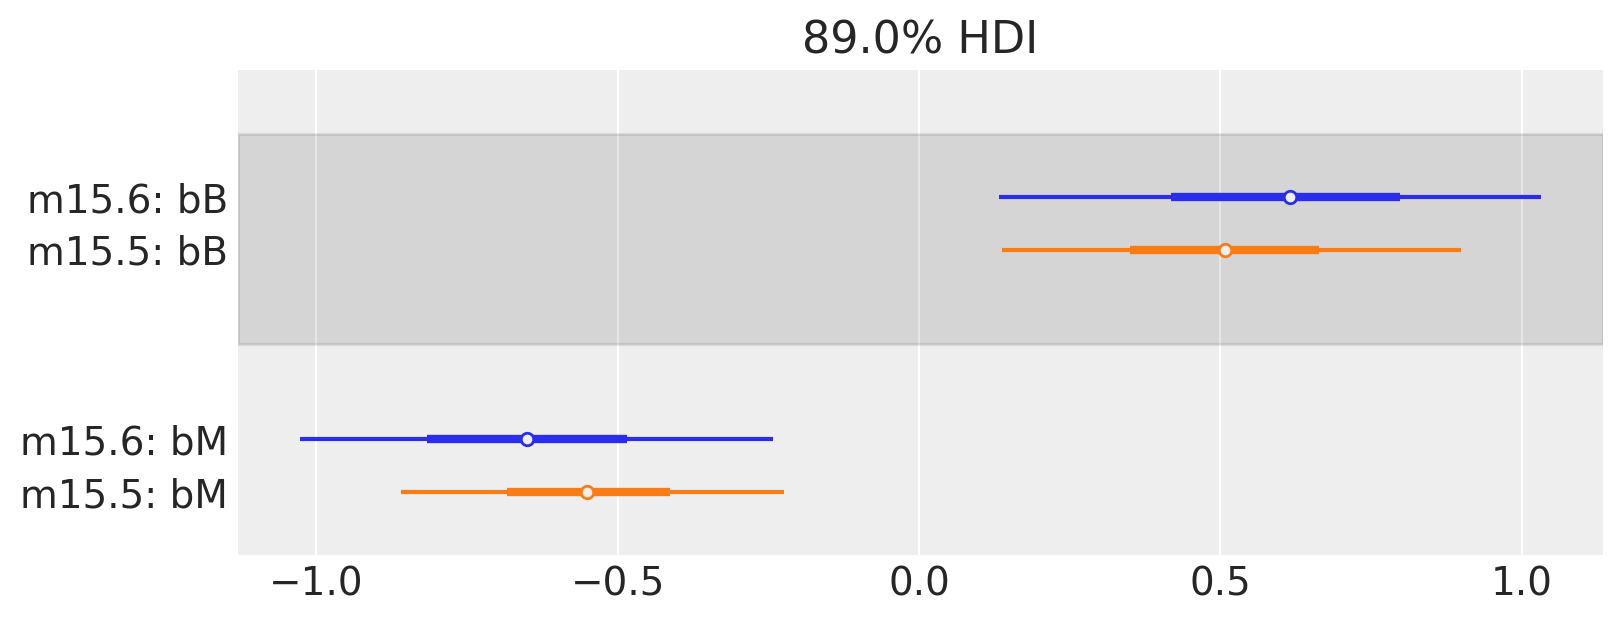

In [17]:
az.plot_forest(
    [idata_m15_6, idata_m15_5], 
    model_names=['m15.6', 'm15.5'], 
    var_names=['bB', 'bM'],
    combined=True,
    figsize=(8, 3)
);

#### Code 15.21

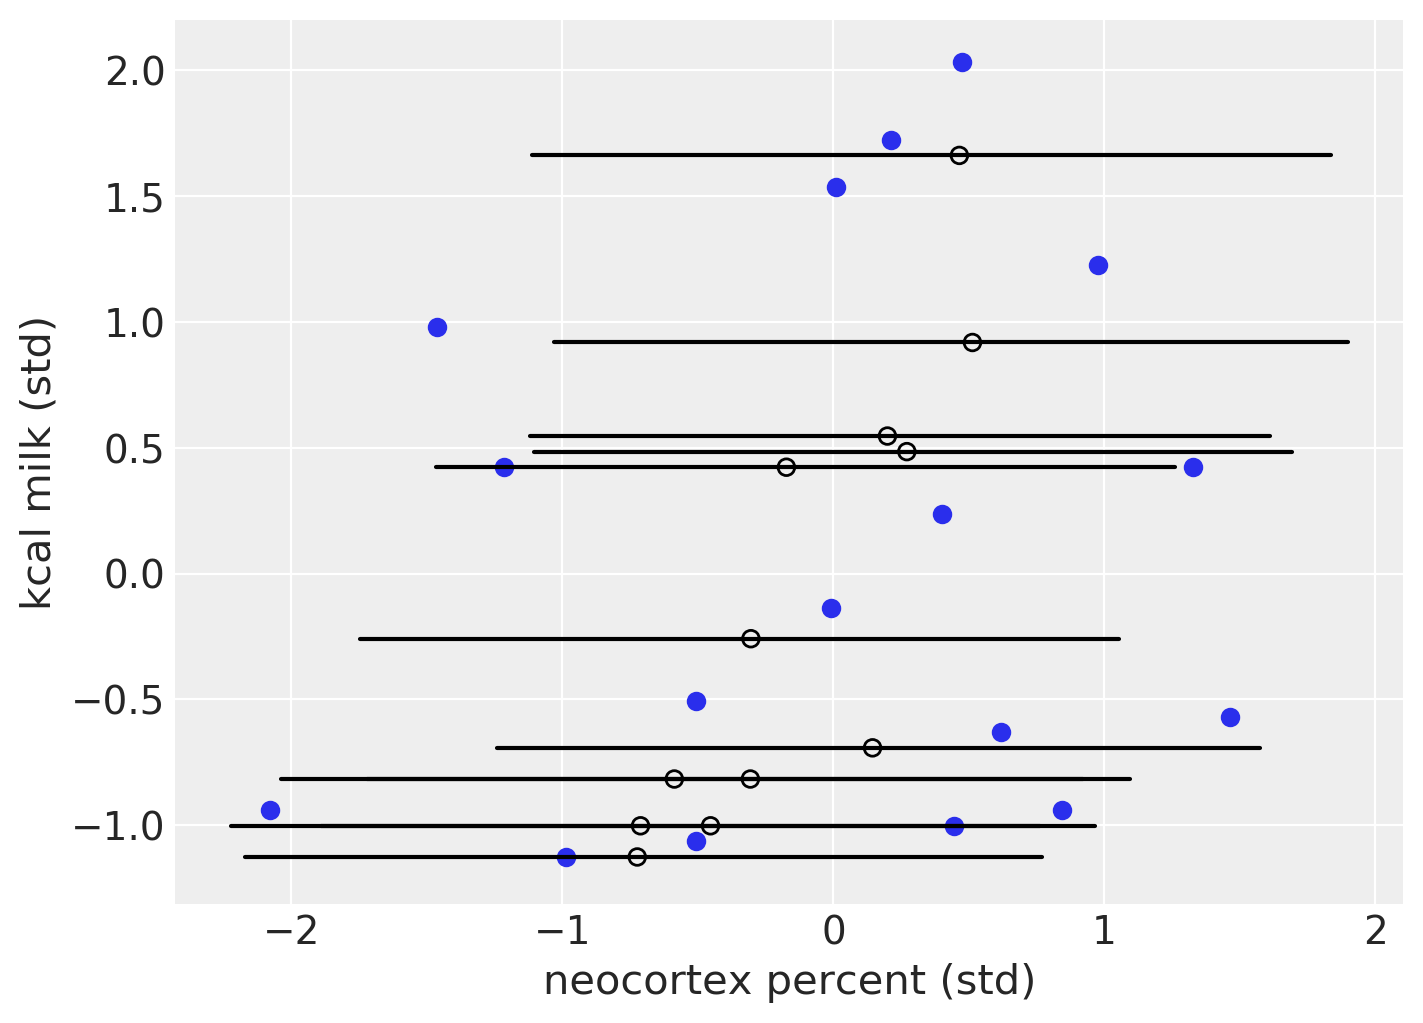

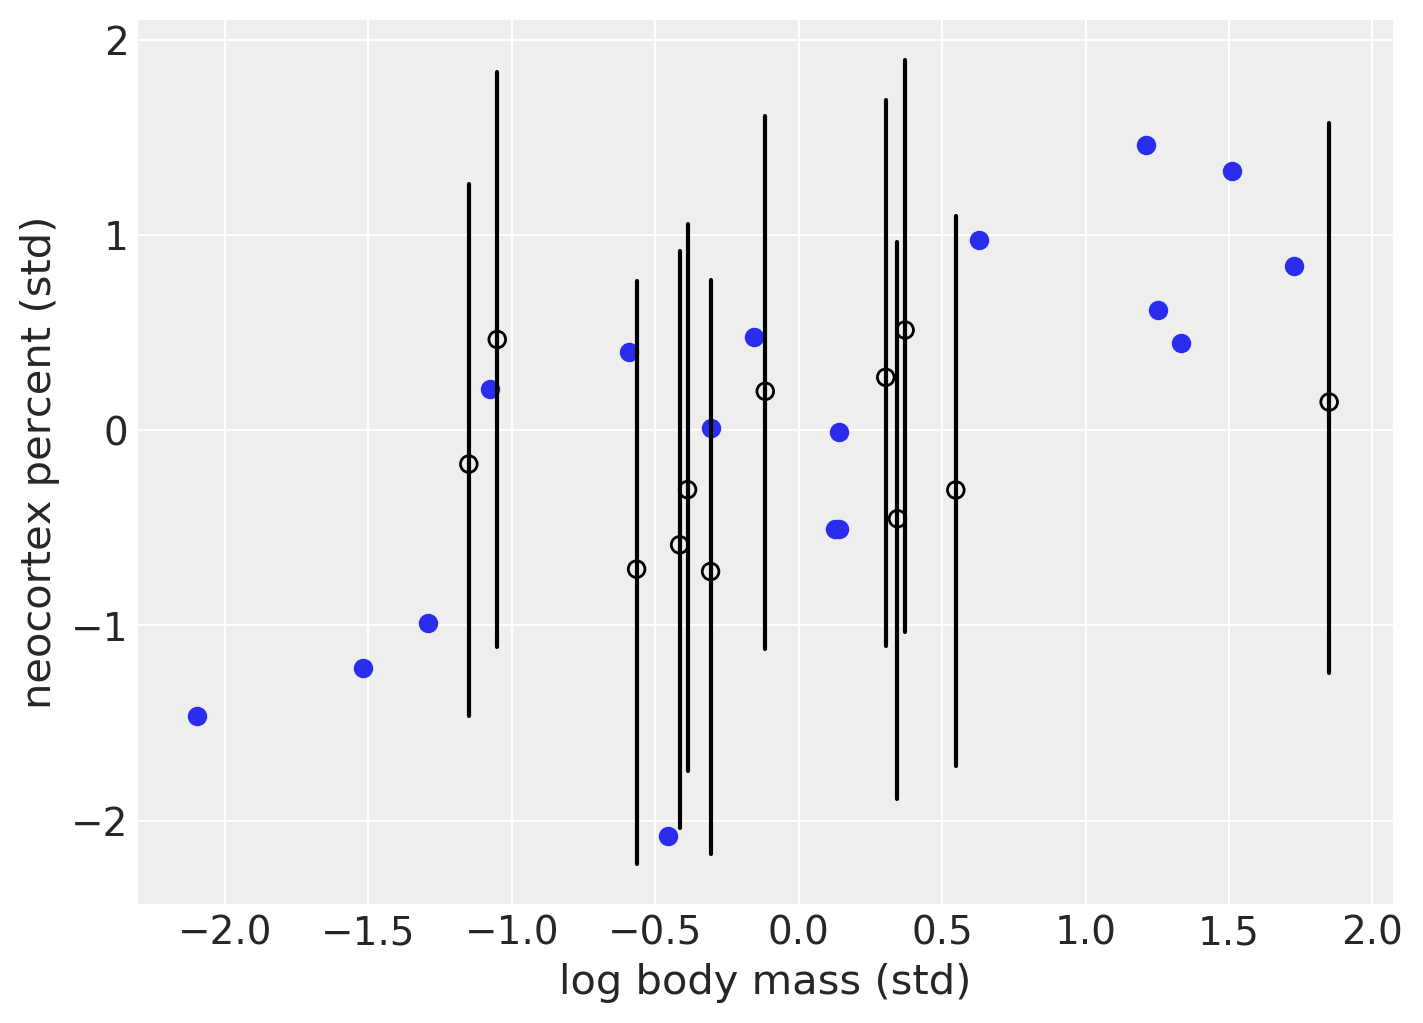

In [18]:
post = idata_m15_5.posterior

B_impute_mu = post['Bi_missing'].mean(dim=['chain', 'draw'])
B_impute_ci = az.hdi(post, var_names=['Bi_missing'])['Bi_missing']

# B vs K
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(B, K)
ax.scatter(B_impute_mu, K[~obs_idx], edgecolor='k', facecolor='none')
ax.plot([B_impute_ci.sel(hdi='lower'), B_impute_ci.sel(hdi='higher')], 
        [K[~obs_idx], K[~obs_idx]], 
        color='k')
ax.set_xlabel('neocortex percent (std)')
ax.set_ylabel('kcal milk (std)');

# M vs B
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M, B)
ax.scatter(M[~obs_idx], B_impute_mu, edgecolor='k', facecolor='none')
ax.plot([M[~obs_idx], M[~obs_idx]],
        [B_impute_ci.sel(hdi='lower'), B_impute_ci.sel(hdi='higher')], 
        color='k')
ax.set_xlabel('log body mass (std)')
ax.set_ylabel('neocortex percent (std)');

#### Code 15.22

In [19]:
MB_masked = np.ma.masked_invalid(np.stack([M, B]).T)

with pm.Model() as m15_7:
    sigma = pm.Exponential('sigma', 1)
    muM = pm.Normal('muM', 0, 0.5)
    muB = pm.Normal('muB', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)
    bB = pm.Normal('bB', 0, 0.5)
    a = pm.Normal('a', 0, 0.5) 
    
    chol, _, _ = pm.LKJCholeskyCov(
        'chol_cov', n=2, eta=2, sd_dist=pm.Exponential.dist(1), compute_corr=True
    )
    
    MB = pm.MvNormal('MB', mu=tt.stack([muM, muB]), chol=chol, observed=MB_masked)
    
    mu = a + bB*MB[:, 1] + bM*M
    
    Ki = pm.Normal('Ki', mu, sigma, observed=K)
    
    idata_m15_7 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
    
idata_m15_7.posterior = idata_m15_7.posterior.rename_vars(
    {'chol_cov_corr': 'Rho_MB'}
)
az.summary(idata_m15_7, var_names=['bM', 'bB', 'Rho_MB'], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [MB_missing, chol_cov, a, bB, bM, muB, muM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.64,0.22,-1.01,-0.29,0.00,0.0,2450.22,2450.22,2481.41,2646.16,1.0
bB,0.58,0.26,0.18,1.01,0.01,0.0,2041.95,2041.95,2055.85,2344.33,1.0
"Rho_MB[0,0]",1.00,0.00,1.00,1.00,0.00,0.0,4000.00,4000.00,4000.00,4000.00,NaN
"Rho_MB[0,1]",0.61,0.13,0.41,0.81,0.00,0.0,3660.79,3605.93,3595.88,2786.02,1.0
"Rho_MB[1,0]",0.61,0.13,0.41,0.81,0.00,0.0,3660.79,3605.93,3595.88,2786.02,1.0
"Rho_MB[1,1]",1.00,0.00,1.00,1.00,0.00,0.0,4000.00,4000.00,3759.26,3739.27,1.0


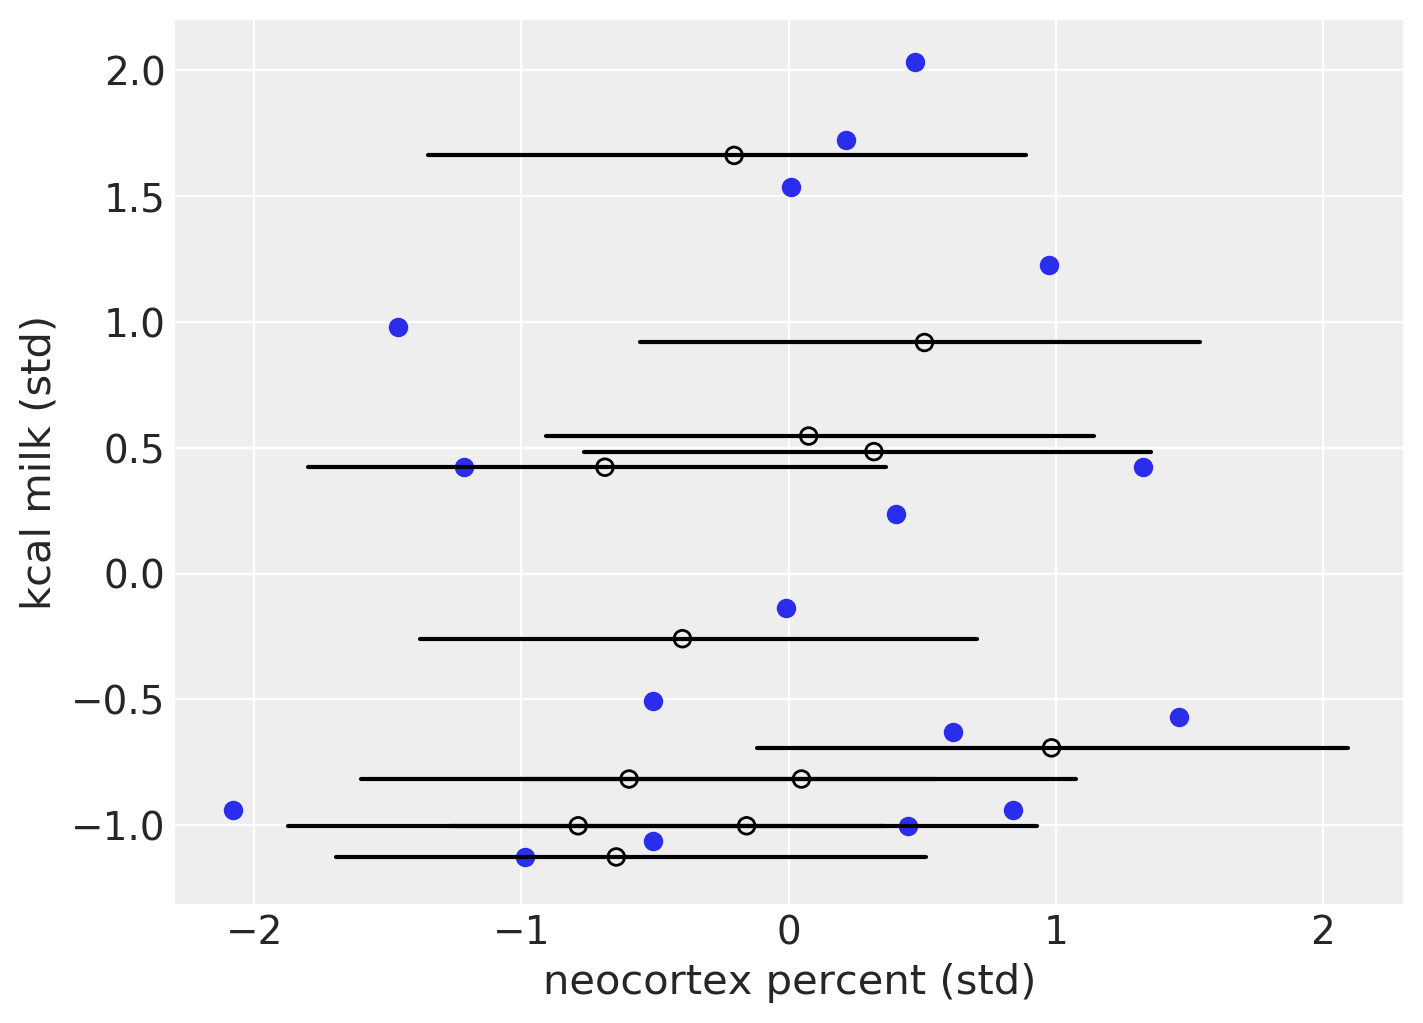

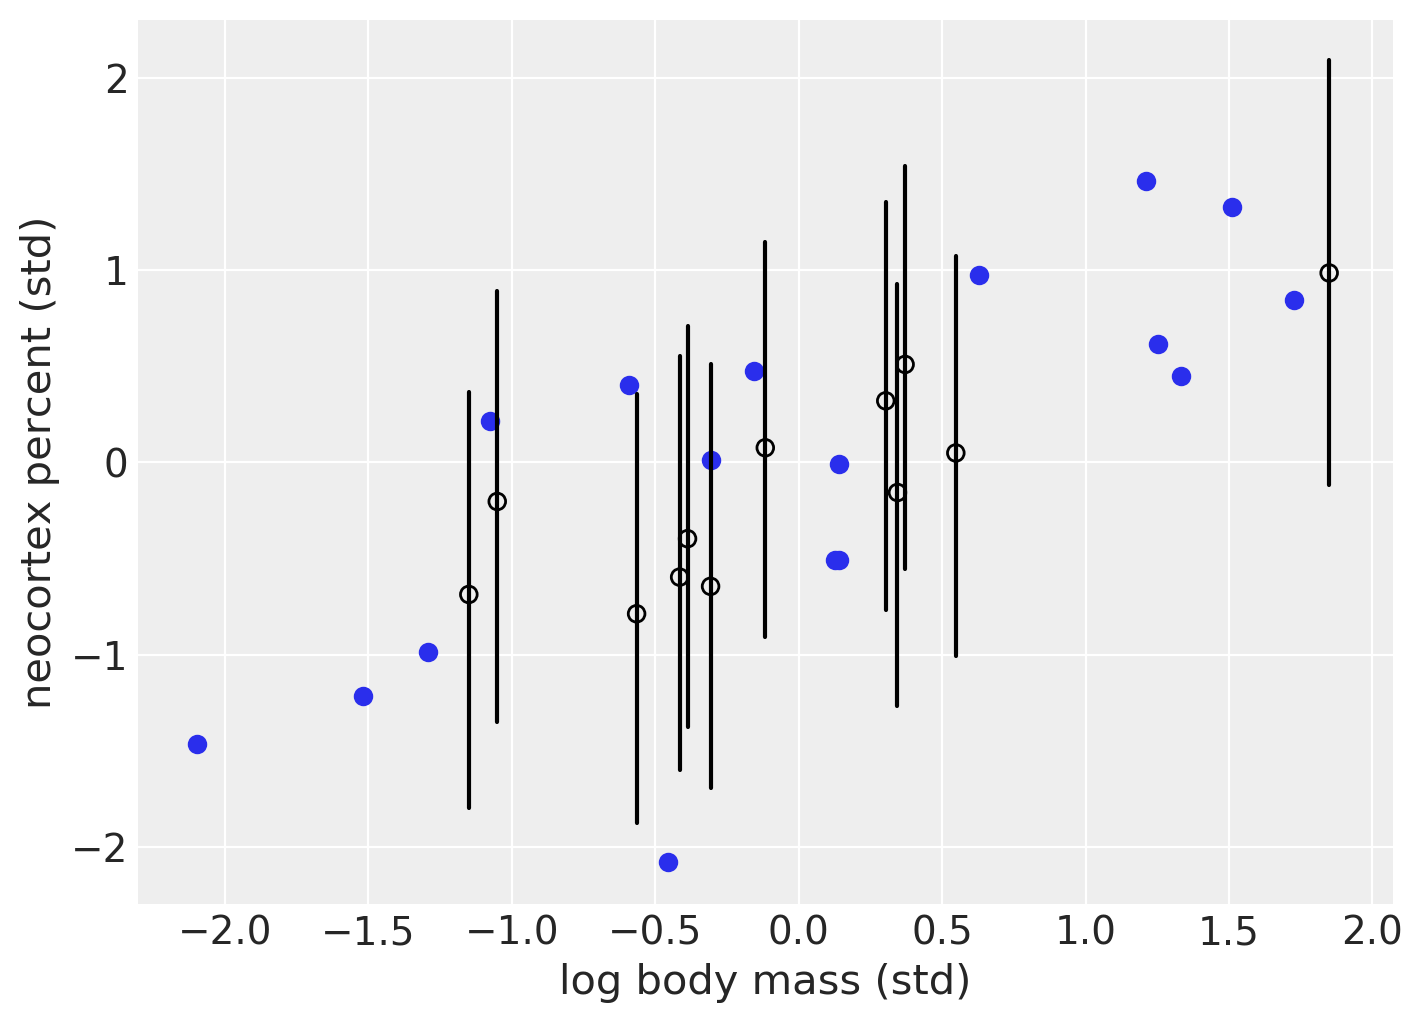

In [20]:
post = idata_m15_7.posterior

B_impute_mu = post['MB_missing'].mean(dim=['chain', 'draw'])
B_impute_ci = az.hdi(post, var_names=['MB_missing'])['MB_missing']

# B vs K
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(B, K)
ax.scatter(B_impute_mu, K[~obs_idx], edgecolor='k', facecolor='none')
ax.plot([B_impute_ci.sel(hdi='lower'), B_impute_ci.sel(hdi='higher')], 
        [K[~obs_idx], K[~obs_idx]], 
        color='k')
ax.set_xlabel('neocortex percent (std)')
ax.set_ylabel('kcal milk (std)');

# M vs B
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M, B)
ax.scatter(M[~obs_idx], B_impute_mu, edgecolor='k', facecolor='none')
ax.plot([M[~obs_idx], M[~obs_idx]],
        [B_impute_ci.sel(hdi='lower'), B_impute_ci.sel(hdi='higher')], 
        color='k')
ax.set_xlabel('log body mass (std)')
ax.set_ylabel('neocortex percent (std)');

#### Code 15.29

In [21]:
N_houses = 100
alpha = 5
beta = -3
k = 0.5
r = 0.2

cat_true = rng.binomial(n=1, p=k, size=N_houses)
notes = rng.poisson(lam=alpha + beta*cat_true, size=N_houses)
R_C = rng.binomial(n=1, p=r, size=N_houses)
cat = cat_true.copy()
cat[R_C==1] = -9

#### Code 15.30

In [22]:
with pm.Model() as m15_8:
    # priors
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 0.5)
    k = pm.Beta('k', 2, 2)
    
    # cat NA
    custom_logp = pm.math.logsumexp([
        pm.math.log(k) + pm.Poisson.dist(pm.math.exp(a + b)).logp(notes[cat==-9]) + 
        pm.math.log(1-k) + pm.Poisson.dist(pm.math.exp(a)).logp(notes[cat==-9])
        ], axis=1
    )
    notes_RC_1 = pm.Potential('notes|RC==1', custom_logp)
    
    # cat known present/absent
    cat_RC_0 = pm.Bernoulli('cat|RC==0', k, observed=cat[cat!=-9])
    lam = pm.math.exp(a + b*cat_RC_0)
    notes_RC_0 = pm.Poisson('notes|RC==0', lam, observed=notes[cat!=-9])
    
    idata_m15_8 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
az.summary(idata_m15_8, var_names=['a', 'b', 'k'], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.55,0.07,1.44,1.65,0.0,0.0,4157.12,4148.01,4146.18,2835.36,1.0
b,-1.06,0.14,-1.28,-0.82,0.0,0.0,3916.44,3817.40,3950.79,3033.26,1.0
k,0.43,0.05,0.34,0.51,0.0,0.0,4110.86,4050.58,4118.88,2639.14,1.0


In [23]:
print(f'a data generating process = {round(np.log(alpha), 2)}')
print(f'b data generating process = {round(np.log(alpha+beta)-np.log(alpha), 2)}')

a data generating process = 1.61
b data generating process = -0.92


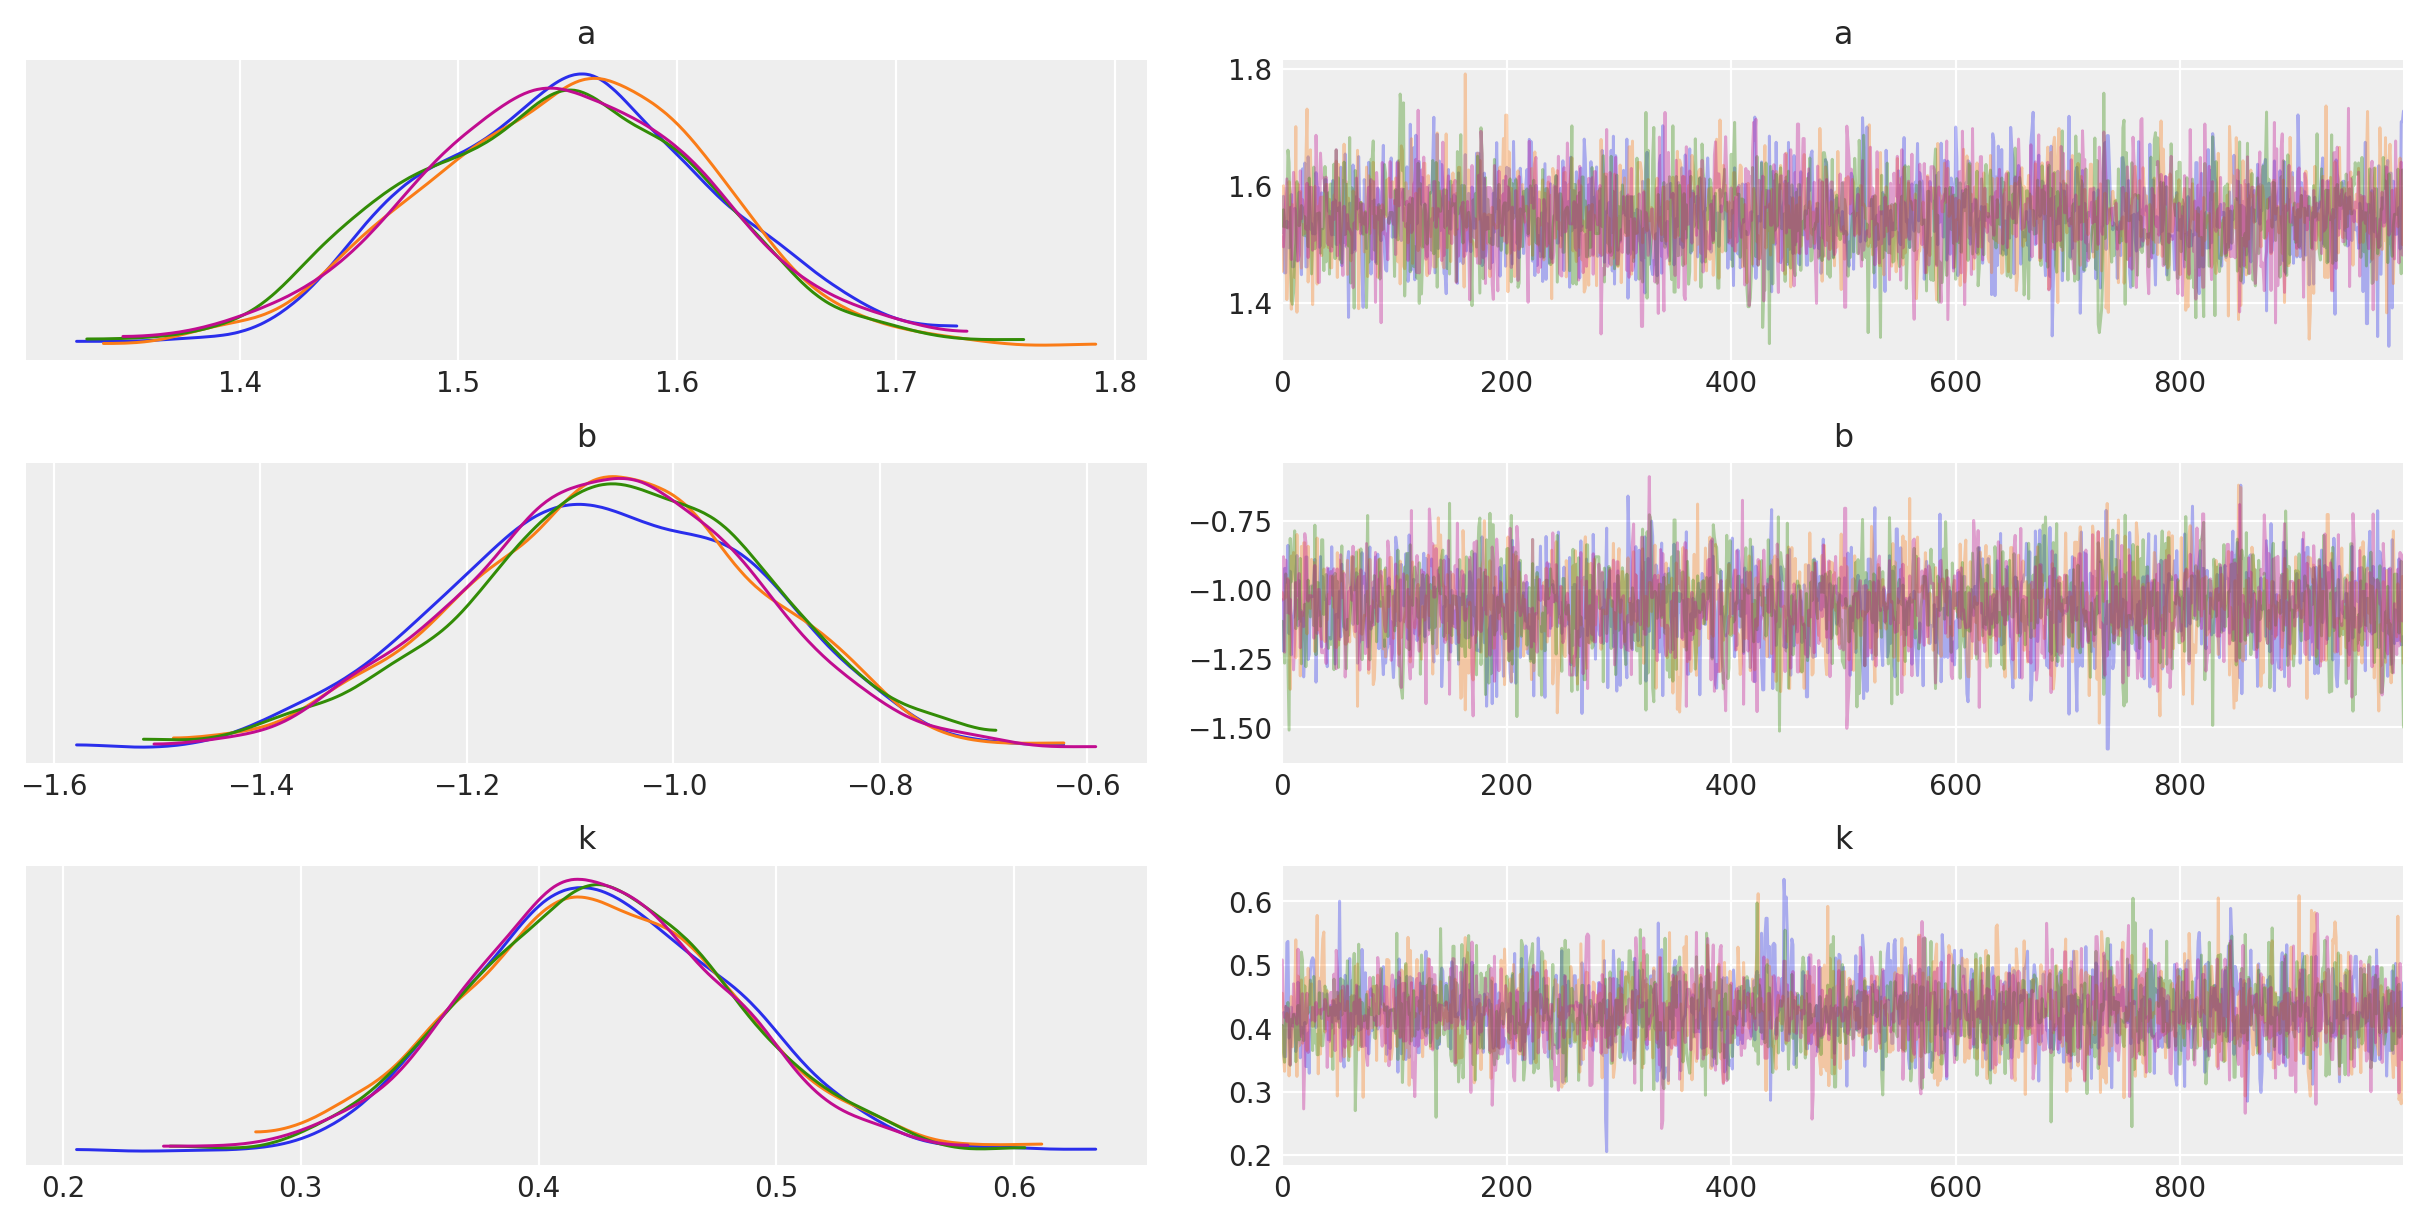

In [24]:
az.plot_trace(idata_m15_8, var_names=['a', 'b', 'k']);

#### Code 15.31

In [25]:
with pm.Model() as m15_9:
    # priors
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 0.5)
    k = pm.Beta('k', 2, 2)
    
    # cat NA
    custom_logp = pm.math.logsumexp([
        pm.math.log(k) + pm.Poisson.dist(pm.math.exp(a + b)).logp(notes[cat==-9]) + 
        pm.math.log(1-k) + pm.Poisson.dist(pm.math.exp(a)).logp(notes[cat==-9])
        ], axis=1
    )
    notes_RC_1 = pm.Potential('notes|RC==1', custom_logp)
    
    # cat known present/absent
    cat_RC_0 = pm.Bernoulli('cat|RC==0', k, observed=cat[cat!=-9])
    lam = pm.math.exp(a + b*cat_RC_0)
    notes_RC_0 = pm.Poisson('notes|RC==0', lam, observed=notes[cat!=-9])
    
    # imputed values
    lpC0 = pm.Deterministic('lpC0', 
        pm.math.log(1-k) + pm.Poisson.dist(pm.math.exp(a)).logp(notes)
    )
    lpC1 = pm.Deterministic('lpC1', 
        pm.math.log(k) + pm.Poisson.dist(pm.math.exp(a + b)).logp(notes)
    )
    PrC1 = pm.Deterministic('PrC1', 
        pm.math.exp(lpC1) / (pm.math.exp(lpC1) + pm.math.exp(lpC0))
    )
    
    idata_m15_9 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
az.summary(idata_m15_9, var_names=['a', 'b', 'k'], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.55,0.07,1.44,1.65,0.0,0.0,4157.12,4148.01,4146.18,2835.36,1.0
b,-1.06,0.14,-1.28,-0.82,0.0,0.0,3916.44,3817.40,3950.79,3033.26,1.0
k,0.43,0.05,0.34,0.51,0.0,0.0,4110.86,4050.58,4118.88,2639.14,1.0


In [26]:
PrC1_hdi = az.hdi(idata_m15_9.posterior['PrC1'])['PrC1']

sorted_cats = np.argsort(cat_true)
cat_true_sorted = cat_true[sorted_cats]
PrC1_hdi_sorted = PrC1_hdi[sorted_cats]
cat_obs_sorted = cat[sorted_cats]

cat_obs_sorted[cat_obs_sorted==-9] = 2

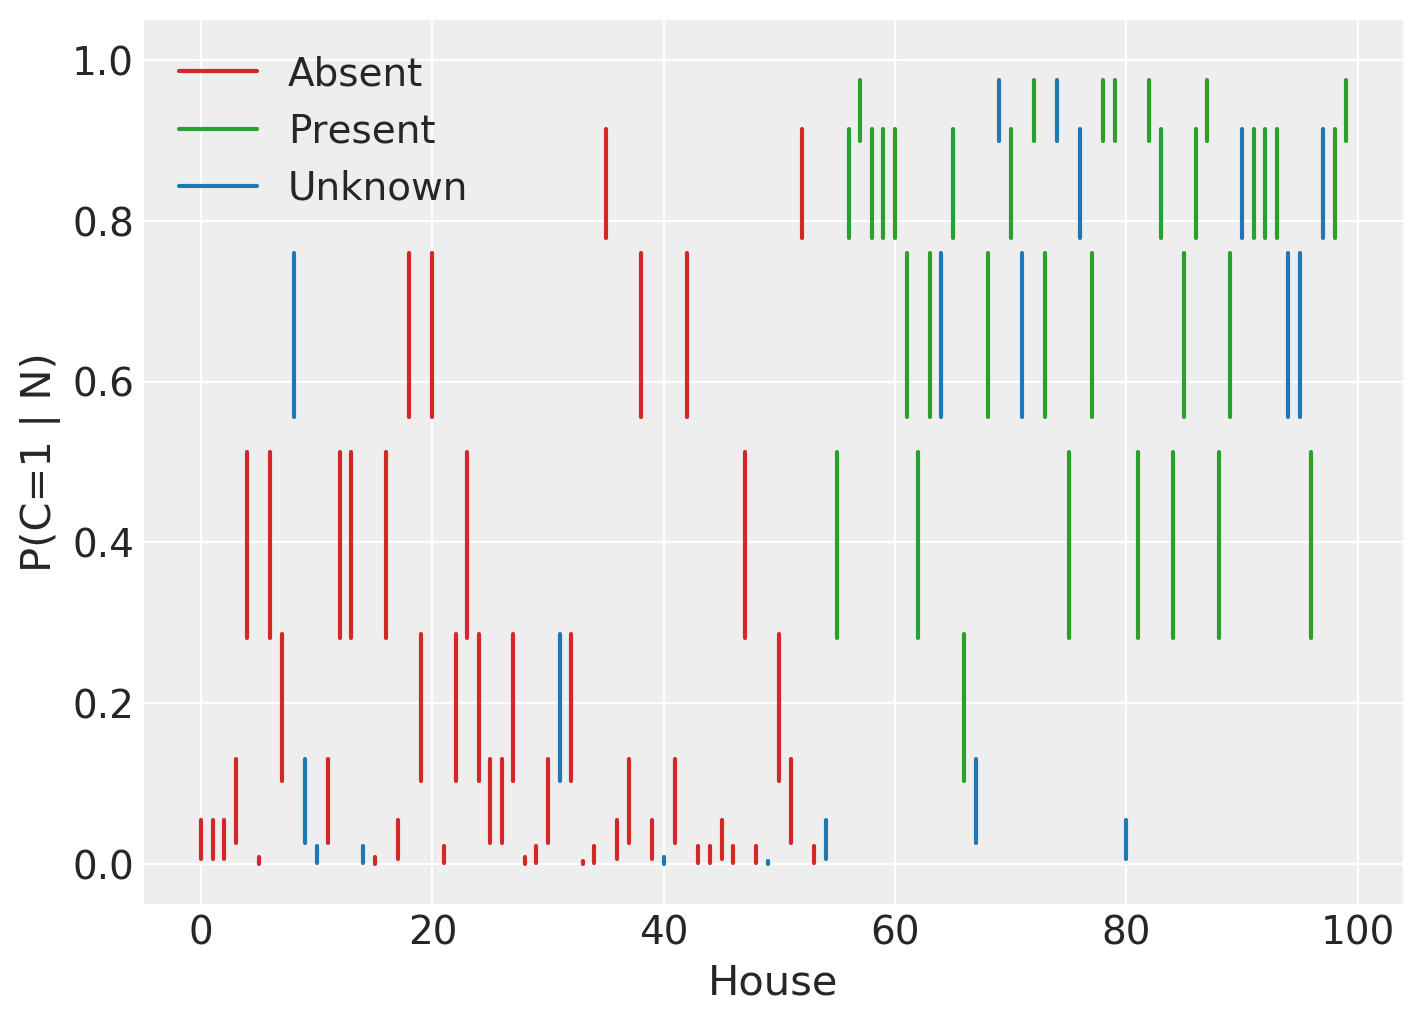

In [27]:
labels = ['Absent', 'Present', 'Unknown']
colours = ['tab:red', 'tab:green', 'tab:blue']

fig, ax = plt.subplots(figsize=(7, 5))
for i in range(3):
    idx = cat_obs_sorted==i
    ax.plot([np.flatnonzero(idx), np.flatnonzero(idx)], 
            [PrC1_hdi_sorted[idx, 0], PrC1_hdi_sorted[idx, 1]], 
            color=colours[i])
    ax.axhline(2, color=colours[i], alpha=1, label=labels[i]) # convenient to show labels
    
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('House')
ax.set_ylabel('P(C=1 | N)')
ax.legend();

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas 1.0.3
pymc3  3.9.3
arviz  0.10.0
numpy  1.18.1
last updated: Sat Oct 03 2020 

CPython 3.8.2
IPython 7.14.0
watermark 2.0.2
